In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive
FOLDERNAME = 'Colab Notebooks/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2
%pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer
import torch
from torch.utils.data import Dataset, DataLoader

class TransformerDataset(Dataset):
    def __init__(self, data, targets, normalize=True):
        # Move data to CUDA
        data = data.to(CUDA)

        # Positional encoding across *location*: this lib encodes along the last dimension
        summer = Summer(PositionalEncoding1D(ECoG_ELECTRODES)).to(CUDA)
        pre_data = summer(data.unsqueeze(1))

        # Transformer implementation expects (batch, electrode, time) for electrode encoding
        pre_data = pre_data.permute(0, 2, 1)

        # Normalize data and targets if required
        if normalize:
            # Normalize data by the mean and std of the whole dataset
            self.data_mean = pre_data.mean()
            self.data_std = pre_data.std()
            self.data = (pre_data - self.data_mean) / (self.data_std + 1e-6)

            # Compute and store mean and std for targets along the second dimension
            self.target_mean = targets.mean(dim=0, keepdim=True)
            self.target_std = targets.std(dim=0, keepdim=True)
            self.targets = (targets - self.target_mean) / (self.target_std + 1e-6)
            self.targets = targets.to(CUDA)
        else:
            self.data = pre_data.to(CUDA)
            self.targets = targets.to(CUDA)
            self.data_mean = None
            self.data_std = None
            self.target_mean = None
            self.target_std = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def denormalize_targets(self, normalized_targets):
        """Denormalize the targets using stored mean and std."""
        if self.target_mean is not None and self.target_std is not None:
            return normalized_targets * self.target_std + self.target_mean
        else:
            raise ValueError("Targets were not normalized or mean and std were not saved.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Using cached positional_encodings-6.0.3-py3-none-any.whl (7.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014

In [ ]:
import scipy.io

def load_and_append_data(file_paths, index):
    appended_data = []
    for file_path in file_paths:
        data = scipy.io.loadmat(file_path)
        appended_data.append(data[index])
    return appended_data

EEG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/EEG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/EEG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/EEG_deep-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/EEG_ recovery.mat'

]

EEG_data = load_and_append_data(EEG_file_paths, "EEG")

ECoG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/ECoG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/ECoG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/ECoG_deep-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/ECoG_ recovery.mat'
]

ECoG_data = load_and_append_data(ECoG_file_paths, "ECoG")

In [ ]:
X = torch.tensor(ECoG_data, dtype=torch.float)
y = torch.tensor(EEG_data, dtype=torch.float)

print(X.size())
print(y.size())

torch.Size([4, 128, 300000])
torch.Size([4, 16, 300000])


<ipython-input-22-eb90f3e3509d>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.tensor(ECoG_data, dtype=torch.float)


In [ ]:
X = X.transpose(0, 1).reshape(X.size(1), -1)
print(X.size())

torch.Size([128, 1200000])


In [ ]:
y = y.transpose(0, 1).reshape(y.size(1), -1)
print(y.size())

torch.Size([16, 1200000])


In [ ]:
from sklearn.model_selection import train_test_split

X = X.T
y = y.T

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.9, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, shuffle=False)

In [ ]:
BATCH_SIZE = 100
EPOCH_LEN = 1   # In "time steps"
ECoG_ELECTRODES = X.size(1)
EEG_ELECTRODES = y.size(1)
CUDA = "cuda"

train_dataset = TransformerDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = TransformerDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TransformerDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# NOTE: num_heads must divide input_size!
num_heads = 1
num_layers = 4

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# Training and evaluation function
def train_and_evaluate(xformer, optim, train_loader, val_loader, num_epochs):
    criterion = torch.nn.MSELoss()
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        # Training loop
        xformer.train()
        total_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(CUDA), targets.to(CUDA)
            optim.zero_grad()
            outputs = xformer(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optim.step()
            total_train_loss += loss.item() * data.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation loop
        xformer.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(CUDA), targets.to(CUDA)
                outputs = xformer(data)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item() * data.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(xformer.state_dict())

    return best_model, train_losses, val_losses

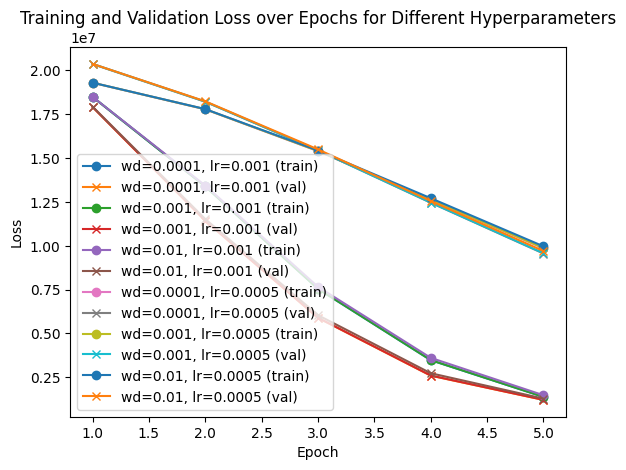

In [ ]:
import model
# Define the hyperparameter grid
learning_rates = [0.001, 0.0005]
weight_decays = [0.0001, 0.001, 0.01]
num_initial_epochs = 5

# Initialize a dictionary to store results
results = {}

# Hyperparameter tuning loop
best_model_params = None
best_val_loss = float('inf')
best_lr = None
best_wd = None

for lr in learning_rates:
    for wd in weight_decays:
        xformer, optim = model.get_transformer(
            input_size=EPOCH_LEN,
            num_layers=num_layers,
            num_heads=num_heads,
            n_embd=EPOCH_LEN,
            out_dim=EEG_ELECTRODES,
            trial_len=ECoG_ELECTRODES,
            cuda=CUDA,
            weight_decay=wd,
            learning_rate=lr
        )

        best_model, train_losses, val_losses = train_and_evaluate(xformer, optim, train_loader, val_loader, num_initial_epochs)
        results[(wd, lr)] = (train_losses, val_losses)

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_params = best_model
            best_lr = lr
            best_wd = wd

# Save the best model
torch.save(best_model_params, '/content/drive/MyDrive/Colab Notebooks/one_object/best_model.pth')

# Plot the loss curves for each combination
for (weight_decay, learning_rate), (train_losses, val_losses) in results.items():
    plt.plot(range(1, num_initial_epochs + 1), train_losses, marker='o', label=f'wd={weight_decay}, lr={learning_rate} (train)')
    plt.plot(range(1, num_initial_epochs + 1), val_losses, marker='x', label=f'wd={weight_decay}, lr={learning_rate} (val)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Different Hyperparameters')
plt.legend()
plt.show()

Epoch 1/10, Train Loss: 18489508.1225, Test Loss: 15413686.535879629
Epoch 2/10, Train Loss: 13386312.785, Test Loss: 10184419.086921297
Epoch 3/10, Train Loss: 7550010.397916666, Test Loss: 5817289.903993055
Epoch 4/10, Train Loss: 3483243.493125, Test Loss: 3208508.1910300925
Epoch 5/10, Train Loss: 1384726.7016145834, Test Loss: 2163961.532071036
Epoch 6/10, Train Loss: 612578.6850195313, Test Loss: 1998500.776743345
Epoch 7/10, Train Loss: 433072.41811035154, Test Loss: 2058437.5719545719
Epoch 8/10, Train Loss: 402923.74766764324, Test Loss: 2081304.630613426
Epoch 9/10, Train Loss: 399555.4617220052, Test Loss: 2074798.057385706
Epoch 10/10, Train Loss: 400068.90869954426, Test Loss: 2067024.8758825231


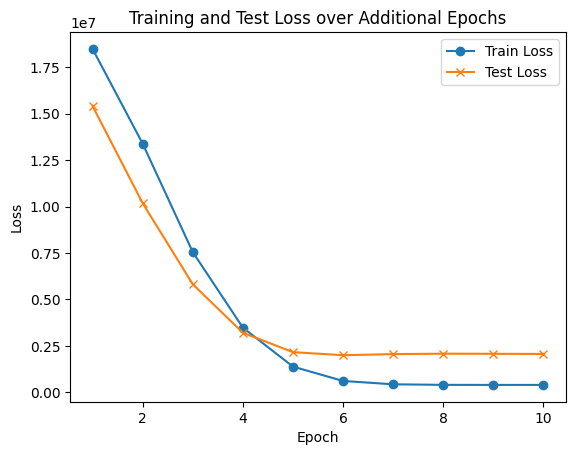

In [ ]:
# Load the best model and optimizer
xformer, optim = model.get_transformer(
    input_size=EPOCH_LEN,
    num_layers=num_layers,
    num_heads=num_heads,
    n_embd=EPOCH_LEN,
    out_dim=EEG_ELECTRODES,
    trial_len=ECoG_ELECTRODES,
    cuda=CUDA,
    weight_decay=0.001,
    learning_rate=0.001
)

# Continue training the best model and evaluate on the test set
test_losses = []
train_losses = []
criterion = torch.nn.MSELoss()
num_additional_epochs = 10

for epoch in range(num_additional_epochs):
    # Training loop
    xformer.train()
    total_train_loss = 0.0
    for data, targets in train_loader:
        data, targets = data.to(CUDA), targets.to(CUDA)
        optim.zero_grad()
        outputs = xformer(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        total_train_loss += loss.item() * data.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Evaluation on the test set
    xformer.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(CUDA), targets.to(CUDA)
            outputs = xformer(data)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item() * data.size(0)

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{num_additional_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

# Plot both training and test loss on the same figure
plt.plot(range(1, num_additional_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_additional_epochs + 1), test_losses, marker='x', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Additional Epochs')
plt.legend()
plt.show()

In [ ]:
torch.save(xformer, '/content/drive/MyDrive/Colab Notebooks/one_object/best_model_10epoch.pth')

# Other monkey object

In [ ]:
EEG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_deep-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/EEG_recovery.mat'

]

EEG_data = load_and_append_data(EEG_file_paths, "EEG")

ECoG_file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_rest.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_low-anesthetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_deep-anethetic.mat',
    '/content/drive/MyDrive/Colab Notebooks/20120123S11_EEGECoG_Su_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG256-EEG17_mat/ECoG_recovery.mat'
]

ECoG_data = load_and_append_data(ECoG_file_paths, "ECoG")

X = torch.tensor(ECoG_data, dtype=torch.float)
y = torch.tensor(EEG_data, dtype=torch.float)

print(X.size())
print(y.size())

torch.Size([4, 256, 300000])
torch.Size([4, 17, 300000])


In [ ]:
X = X.transpose(0, 1).reshape(X.size(1), -1)
print(X.size())
y = y.transpose(0, 1).reshape(y.size(1), -1)
print(y.size())

X = X.T
y = y.T

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.9, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, shuffle=False)


In [ ]:
BATCH_SIZE = 100
EPOCH_LEN = 1   # In "time steps"
ECoG_ELECTRODES = X.size(1)
EEG_ELECTRODES = y.size(1)
CUDA = "cuda"


train_dataset = TransformerDataset(X_train, y_train)
train_loader_Su = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = TransformerDataset(X_val, y_val)
val_loader_Su = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TransformerDataset(X_test, y_test)
test_loader_Su = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Epoch 1/10, Train Loss: 173495367.70666668, Test Loss: 125403197.7925926
Epoch 2/10, Train Loss: 141052324.23333332, Test Loss: 90532591.40833333
Epoch 3/10, Train Loss: 97031241.2, Test Loss: 56458925.50277778
Epoch 4/10, Train Loss: 57142273.48, Test Loss: 33283925.27013889
Epoch 5/10, Train Loss: 28697508.413333334, Test Loss: 23473517.10787037
Epoch 6/10, Train Loss: 12196827.56125, Test Loss: 23296449.53616898
Epoch 7/10, Train Loss: 4600506.3109375, Test Loss: 26288553.090798613
Epoch 8/10, Train Loss: 1903501.512265625, Test Loss: 28275098.347858798
Epoch 9/10, Train Loss: 1181737.5141276042, Test Loss: 28972710.778443288
Epoch 10/10, Train Loss: 1068797.770169271, Test Loss: 29117521.28243634


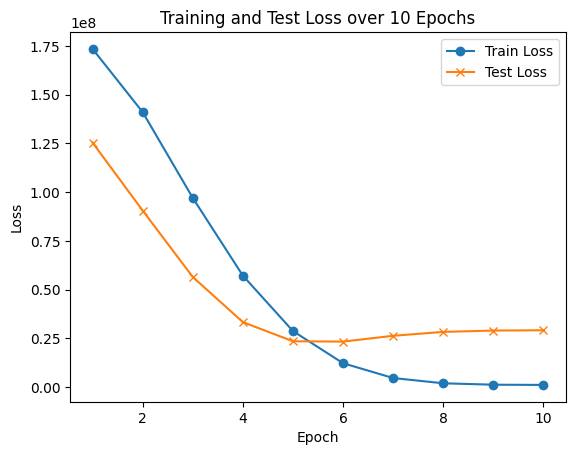

In [ ]:
xformer_Su, optim = model.get_transformer(
    input_size=EPOCH_LEN,
    num_layers=num_layers,
    num_heads=num_heads,
    n_embd=EPOCH_LEN,
    out_dim=EEG_ELECTRODES,
    trial_len=ECoG_ELECTRODES,
    cuda=CUDA,
    weight_decay=0.001,
    learning_rate=0.001
)

# Continue training the best model and evaluate on the test set
test_losses = []
train_losses = []
criterion = torch.nn.MSELoss()
num_additional_epochs = 10

for epoch in range(num_additional_epochs):
    # Training loop
    xformer_Su.train()
    total_train_loss = 0.0
    for data, targets in train_loader_Su:
        data, targets = data.to(CUDA), targets.to(CUDA)
        optim.zero_grad()
        outputs = xformer_Su(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        total_train_loss += loss.item() * data.size(0)

    avg_train_loss = total_train_loss / len(train_loader_Su.dataset)
    train_losses.append(avg_train_loss)

    # Evaluation on the test set
    xformer_Su.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader_Su:
            data, targets = data.to(CUDA), targets.to(CUDA)
            outputs = xformer_Su(data)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item() * data.size(0)

    avg_test_loss = total_test_loss / len(test_loader_Su.dataset)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{num_additional_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

# Plot both training and test loss on the same figure
plt.plot(range(1, num_additional_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_additional_epochs + 1), test_losses, marker='x', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over 10 Epochs')
plt.legend()
plt.show()

torch.save(xformer_Su, '/content/drive/MyDrive/Colab Notebooks/one_object/best_model_10epoch_su.pth')